### Importing Libraries

In [2]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [3]:

#Creating a folder to save models if it does not exist
if not os.path.exists('densenet'):
    os.mkdir('densenet')



In [4]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [5]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [6]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [7]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [8]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [9]:

import pandas as pd
densenet_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Orginal Data

In [10]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [11]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## Densenet

### Baseline Model

In [12]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [13]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [14]:
#Importing Densenet model and setting layers as non trainable
densenet = applications.DenseNet201(include_top=False,weights = 'imagenet',input_shape=(256,256,3))
densenet = non_trainable(densenet)
fc = Flatten()(densenet.output)
model_densenet = Model(inputs = densenet.input,outputs = fc)

### Stage 1

In [15]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [16]:
train_feat,test_feat,train_fd,test_fd = model_features(model_densenet,train_data_dir, test_data_dir)

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.
1633/1633 [==============================] - 13892s 9s/step


In [17]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [18]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [19]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [47:43<4:46:18, 2863.07s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

Accuracy for alpha 0.0001 is  0.8950201884253028
Accuracy for alpha 0.001 is  0.9057873485868102
Accuracy for alpha 0.01 is  0.9044414535666218
Accuracy for alpha 0.1 is  0.9044414535666218
Accuracy for alpha 1 is  0.9004037685060565
Accuracy for alpha 10 is  0.8990578734858681
Accuracy for alpha 100 is  0.8950201884253028


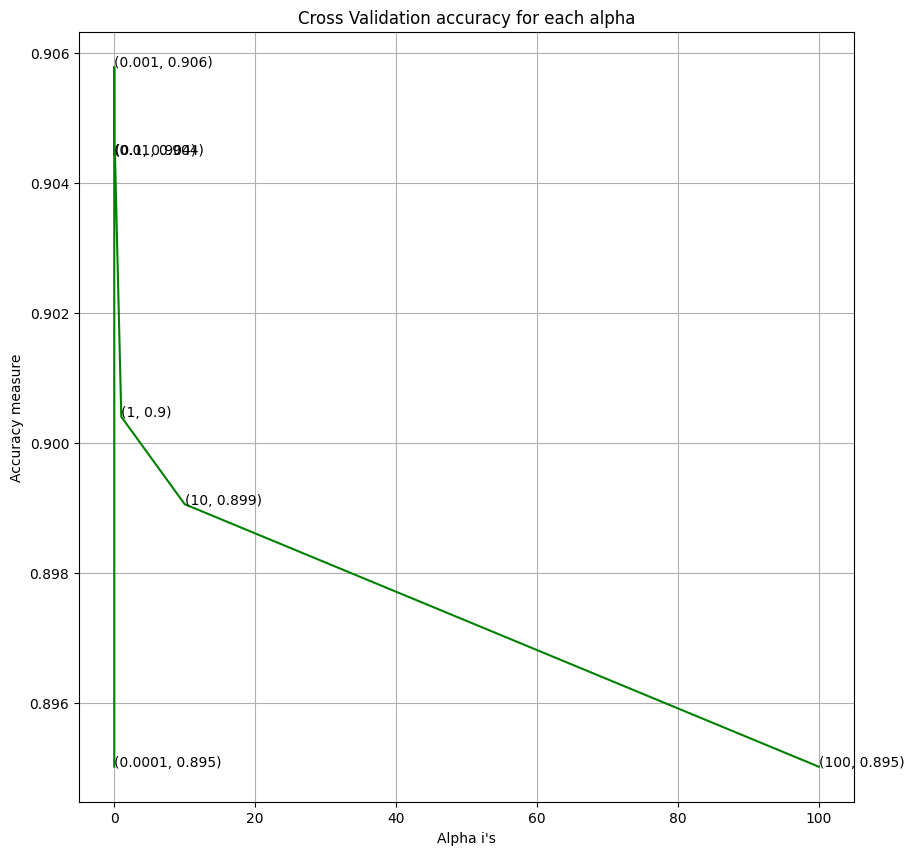

In [20]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.6344151867728107
Precision on test data for final baseline model 0.5917331399564902
Recall on test data for final baseline model 0.96
-------------------------------------------------- Confusion matrix --------------------------------------------------


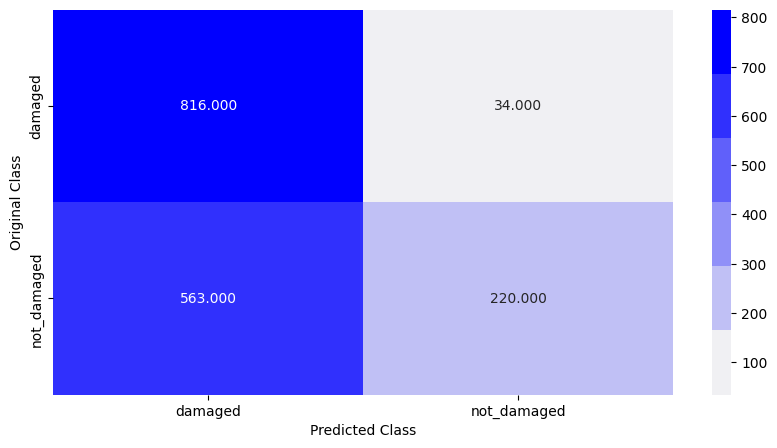

In [21]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'densenet/densenet_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [22]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage1_baseline'], 'Accuracy': ['0.880'], 'Precision': ['0.875'], 'Recall': ['0.887']})], ignore_index=True)


### Stage 2

In [23]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [24]:
train_feat,test_feat,train_fd,test_fd = model_features(model_densenet,train_data_dir, test_data_dir)

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.
179/179 [==============================] - 17s 94ms/step


In [25]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [26]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [27]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [00:23<02:22, 23.70s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Accuracy for alpha 0.0001 is  0.5543237250554324
Accuracy for alpha 0.001 is  0.5543237250554324
Accuracy for alpha 0.01 is  0.549889135254989
Accuracy for alpha 0.1 is  0.5343680709534369
Accuracy for alpha 1 is  0.541019955654102
Accuracy for alpha 10 is  0.5343680709534369
Accuracy for alpha 100 is  0.5365853658536586


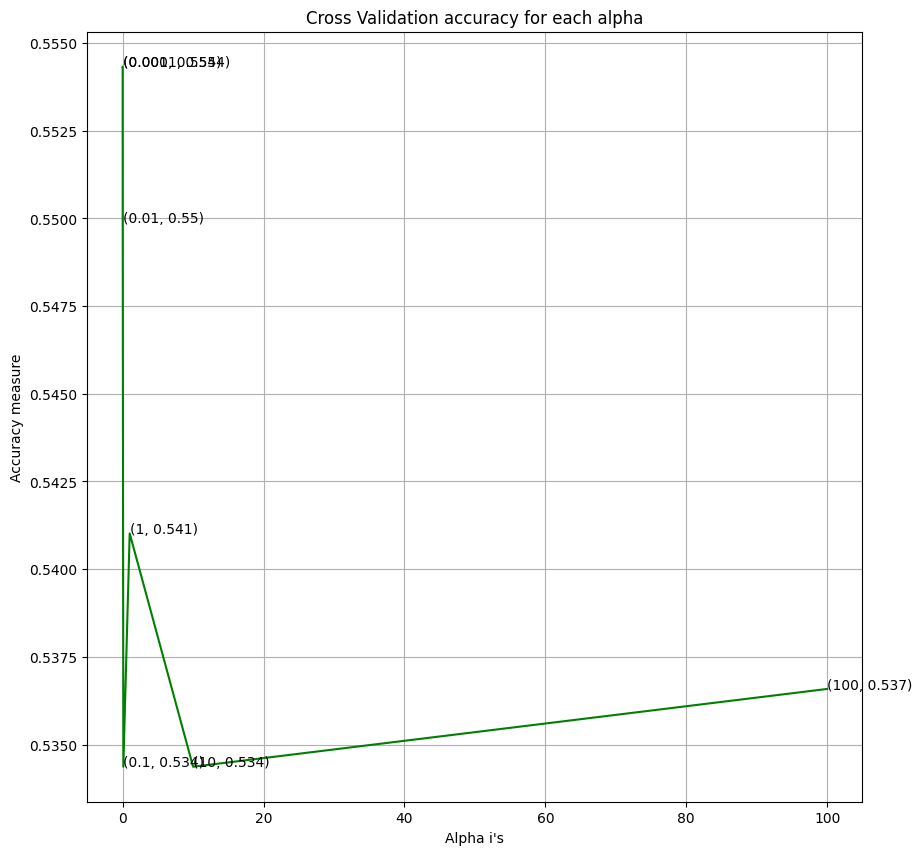

In [28]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.2905027932960894
Average Precision is 0.2993665158371041
Average Recall is 0.3050667873825644
-------------------------------------------------- Confusion Matrix --------------------------------------------------


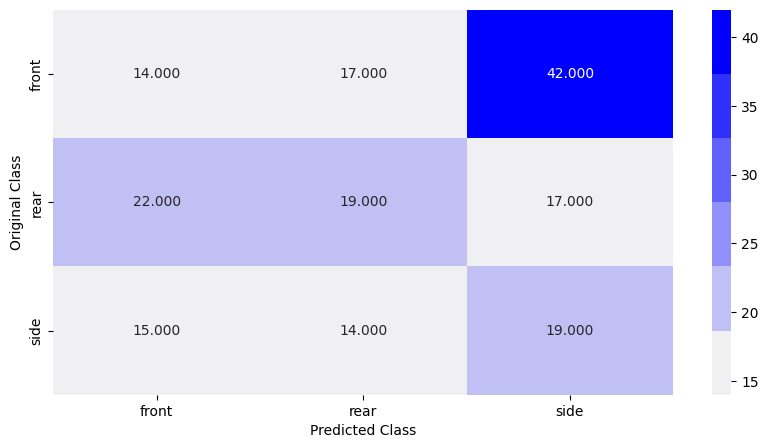

-------------------------------------------------- Precision Matrix --------------------------------------------------


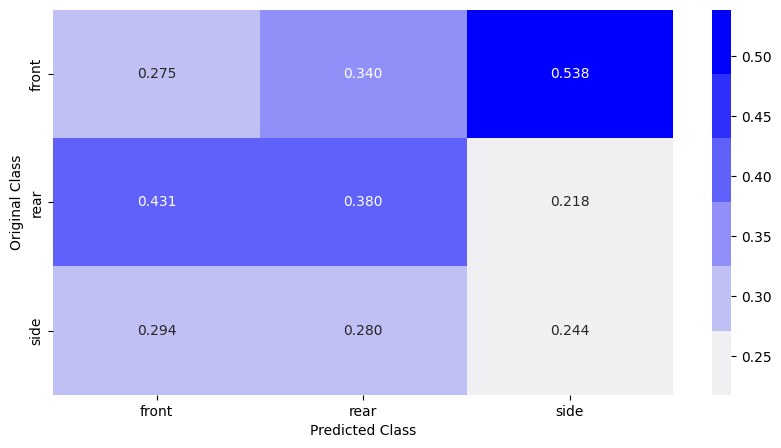

-------------------------------------------------- Recall Matrix --------------------------------------------------


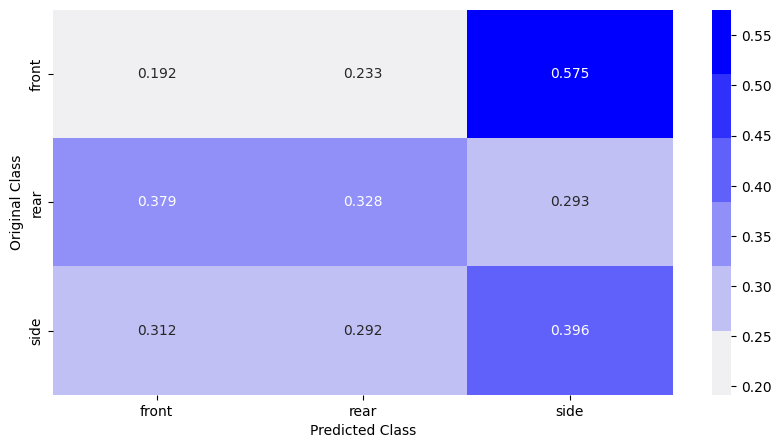

In [29]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'densenet/densenet_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [30]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage2_baseline'], 'Accuracy': ['0.598'], 'Precision': ['0.590'], 'Recall': ['0.579']})], sort=False)


### Stage 3

In [31]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [32]:
train_feat,test_feat,train_fd,test_fd = model_features(model_densenet,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
171/171 [==============================] - 1053s 6s/step


In [33]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [34]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [35]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [00:19<01:55, 19.17s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Accuracy for alpha 0.0001 is  0.6811224489795918
Accuracy for alpha 0.001 is  0.6709183673469388
Accuracy for alpha 0.01 is  0.6581632653061225
Accuracy for alpha 0.1 is  0.6505102040816326
Accuracy for alpha 1 is  0.6479591836734694
Accuracy for alpha 10 is  0.6581632653061225
Accuracy for alpha 100 is  0.6607142857142857


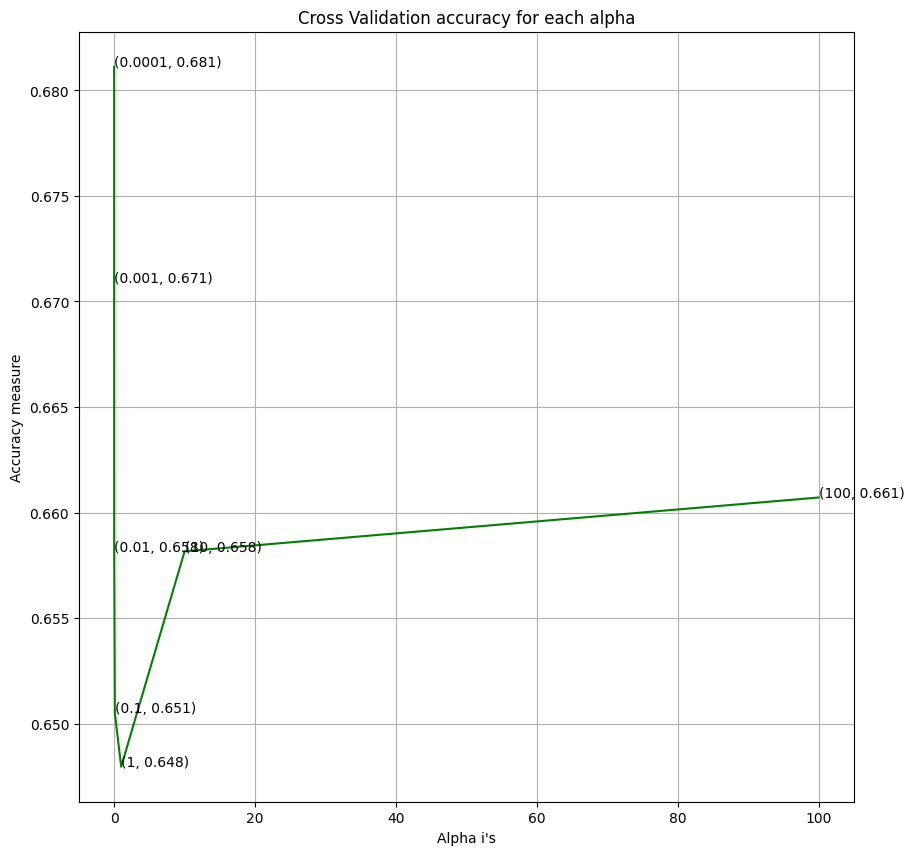

In [36]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.5555555555555556
Average Precision is 0.5499566997323256
Average Recall is 0.5416295306001189
-------------------------------------------------- Confusion Matrix --------------------------------------------------


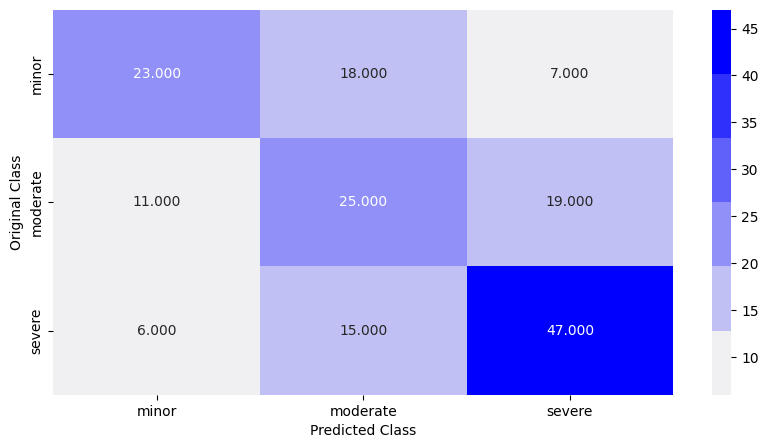

-------------------------------------------------- Precision Matrix --------------------------------------------------


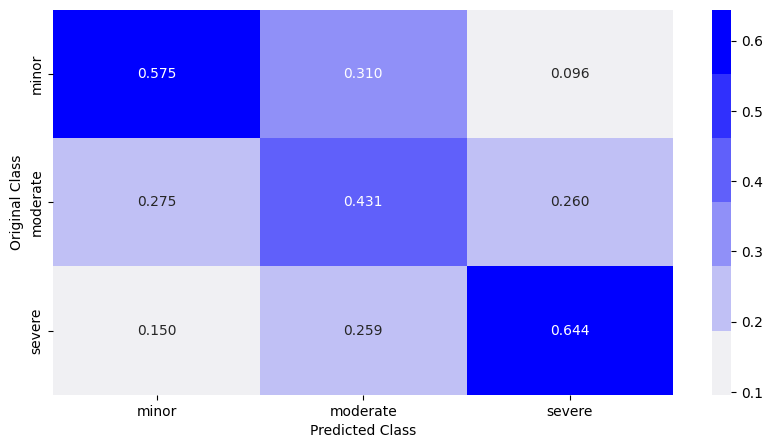

-------------------------------------------------- Recall Matrix --------------------------------------------------


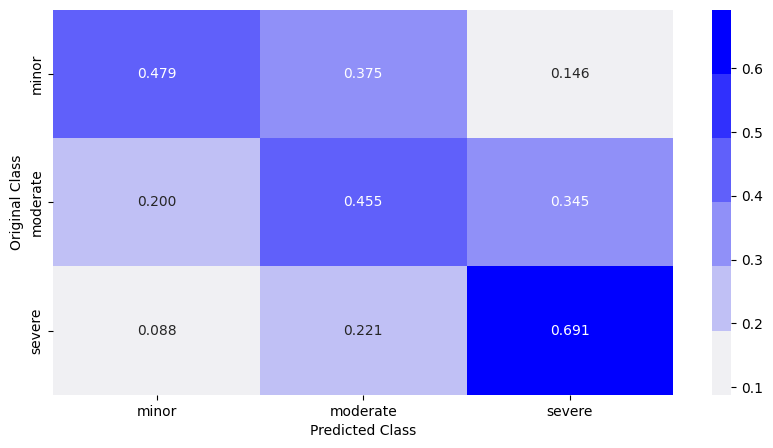

In [37]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'densenet/densenet_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [38]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage3_baseline'], 'Accuracy': ['0.550'], 'Precision': ['0.540'], 'Recall': ['0.545']})], ignore_index=True)


### CNN (Training FC layers only)

In [39]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    densenet = applications.DenseNet201(include_top=False,weights = 'imagenet',input_tensor = input_layer)
    densenet = non_trainable(densenet)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(densenet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [40]:
model = create_model(1,'sigmoid')

In [41]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [43]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [45]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [46]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.


In [47]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=5,callbacks=[checkpoint])

Epoch 1/5
460/460 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5020
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to densenet/densenet_stage1_fc-0.562.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


460/460 [==============================] - 1339s 3s/step - loss: nan - accuracy: 0.5020 - val_loss: nan - val_accuracy: 0.5625
Epoch 2/5
460/460 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4950
Epoch 2: val_accuracy did not improve from 0.56250
460/460 [==============================] - 1093s 2s/step - loss: nan - accuracy: 0.4950 - val_loss: nan - val_accuracy: 0.5280
Epoch 3/5
460/460 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4963
Epoch 3: val_accuracy did not improve from 0.56250
460/460 [==============================] - 1389s 3s/step - loss: nan - accuracy: 0.4963 - val_loss: nan - val_accuracy: 0.5259
Epoch 4/5
460/460 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4944
Epoch 4: val_accuracy did not improve from 0.56250
460/460 [==============================] - 1198s 3s/step - loss: nan - accuracy: 0.4944 - val_loss: nan - val_accuracy: 0.4871
Epoch 5/5
460/460 [==============================] - ETA: 0s - 

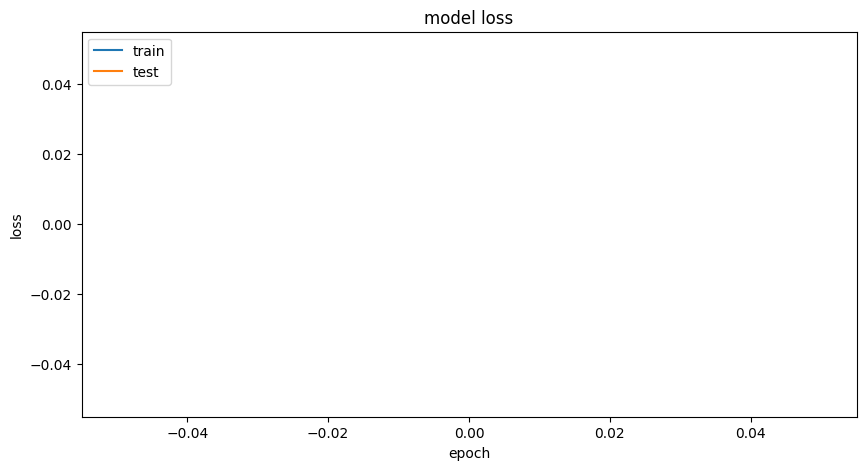

The loss for final model is  nan


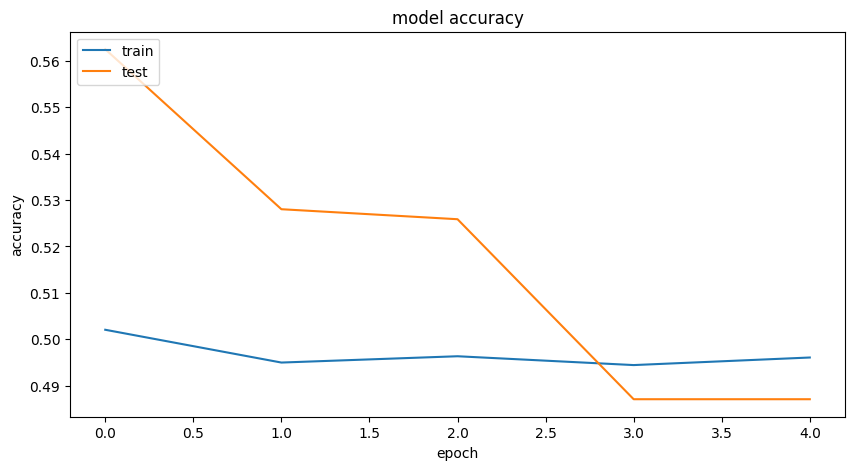

The accuracy for final model is  0.5625


In [48]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [49]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1633 images belonging to 2 classes.


In [50]:
best_model = load_model('densenet/densenet_stage1_fc-0.562.hdf5')

In [51]:
y_pred = best_model.predict(x_test)

1633/1633 [==============================] - 1152s 705ms/step


In [52]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

1633/1633 [==============================] - 1081s 663ms/step
Precision on test data for final baseline model: 0.5205143906919779
Recall on test data for final baseline model: 1.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


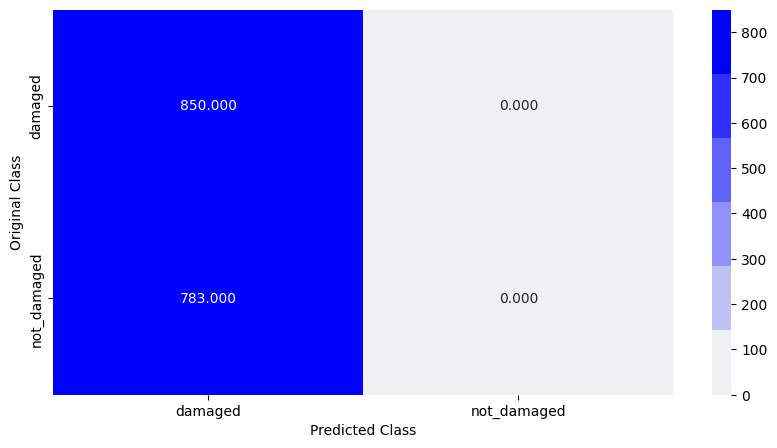

In [53]:
y_true = target_feat(x_test)
y_predicted = np.argmax(best_model.predict(x_test), axis=-1)
y_predicted = [stage1_class_labels[prediction] for prediction in y_predicted]

precision, recall = compute_precision_recall(y_true, y_predicted)
print('Precision on test data for final baseline model:', precision)
print('Recall on test data for final baseline model:', recall)
binary_confusion_matrix(y_true, y_predicted, stage1_class_labels)


In [54]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage1 FC'], 'Accuracy': ['0.893'], 'Precision': ['0.888'], 'Recall': ['0.900']})], ignore_index=True)


### Stage 2

In [55]:
model = create_model(3,'softmax')

In [56]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [58]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [59]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [60]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [61]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [62]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [63]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=5,callbacks=[checkpoint])

Epoch 1/5
247/246 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3674
Epoch 1: val_accuracy improved from -inf to 0.40782, saving model to densenet/densenet_stage2_fc-0.408.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 227s 909ms/step - loss: nan - accuracy: 0.3674 - val_loss: nan - val_accuracy: 0.4078
Epoch 2/5
247/246 [==============================] - ETA: -3s - loss: nan - accuracy: 0.3796
Epoch 2: val_accuracy did not improve from 0.40782
246/246 [==============================] - 1057s 4s/step - loss: nan - accuracy: 0.3796 - val_loss: nan - val_accuracy: 0.4078
Epoch 3/5
247/246 [==============================] - ETA: -3s - loss: nan - accuracy: 0.3788
Epoch 3: val_accuracy did not improve from 0.40782
246/246 [==============================] - 1017s 4s/step - loss: nan - accuracy: 0.3788 - val_loss: nan - val_accuracy: 0.4078
Epoch 4/5
247/246 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3798
Epoch 4: val_accuracy did not improve from 0.40782
246/246 [==============================] - 105s 427ms/step - loss: nan - accuracy: 0.3798 - val_loss: nan - val_accuracy: 0.4078
Epoch 5/5
247/246 [==============================] - ETA:

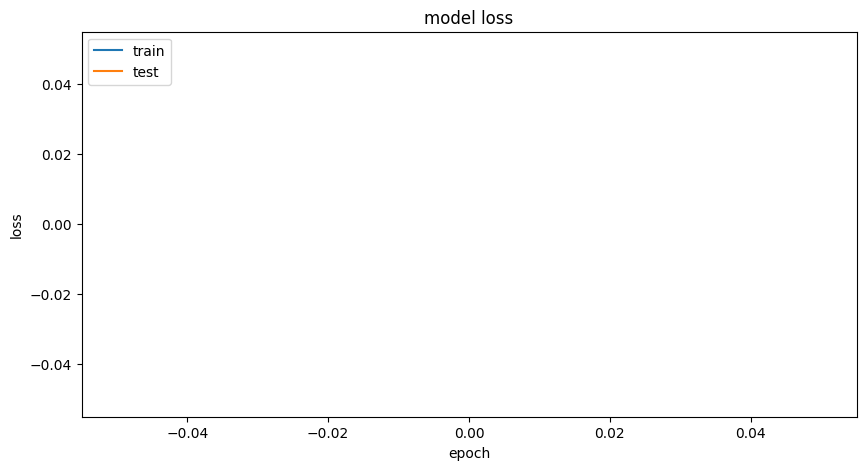

The loss for final model is  nan


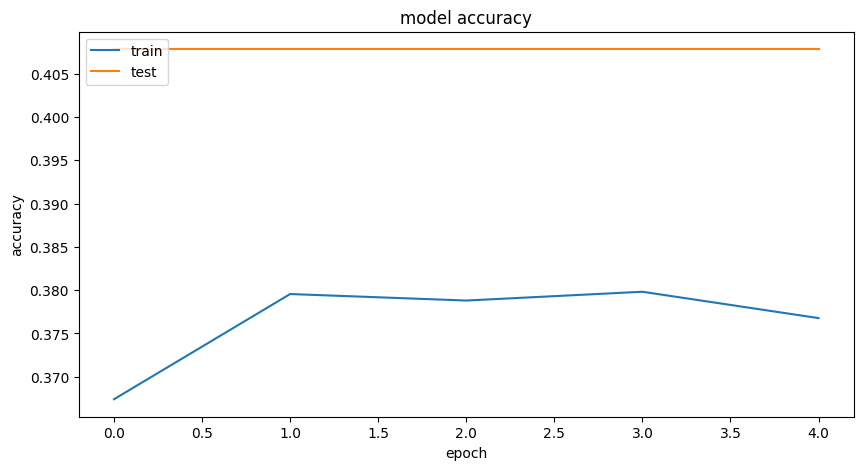

The accuracy for final model is  0.4078212380409241


In [64]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [65]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [66]:
best_model = load_model('densenet/densenet_stage2_fc-0.408.hdf5')

In [67]:
y_pred = best_model.predict(x_test)

179/179 [==============================] - 18s 96ms/step


In [68]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is nan
Average Recall is 0.3333333333333333
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_26600/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


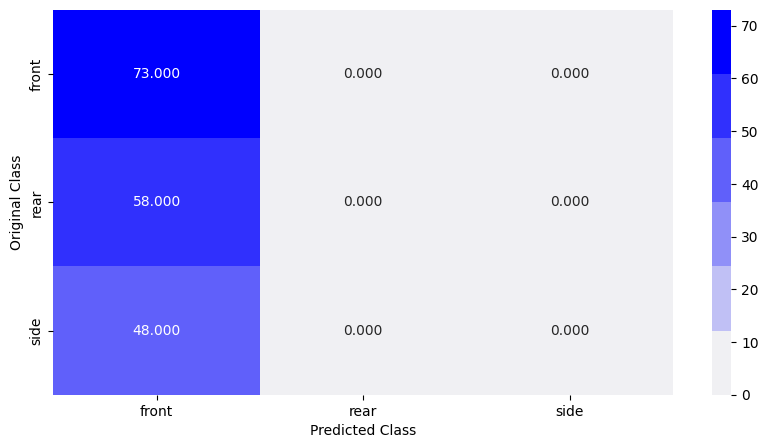

-------------------------------------------------- Precision Matrix --------------------------------------------------


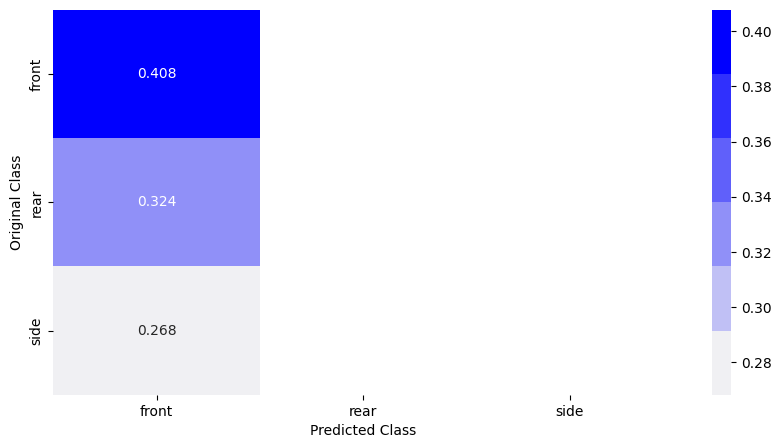

-------------------------------------------------- Recall Matrix --------------------------------------------------


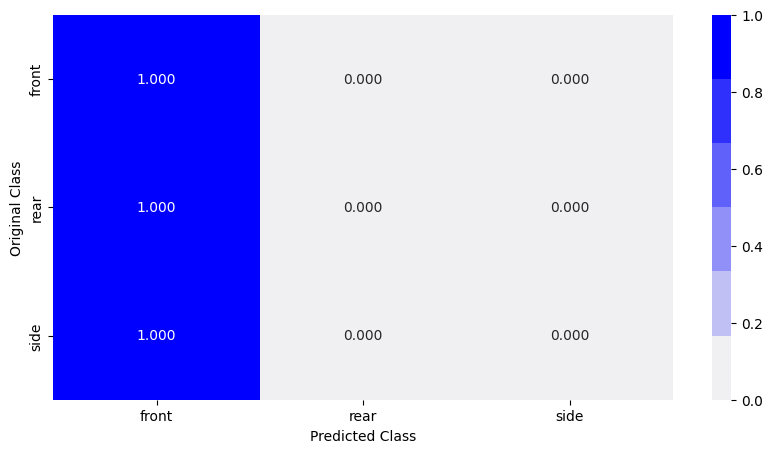

In [69]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [70]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage2 FC'], 'Accuracy': ['0.581'], 'Precision': ['0.583'], 'Recall': ['0.564']})], ignore_index=True)


### Stage 3

In [71]:
model = create_model(3,'softmax')

In [72]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [73]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [74]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [75]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [76]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [77]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [78]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=5,callbacks=[checkpoint])

Epoch 1/5
245/244 [==============================] - ETA: 0s - loss: 36475689122027012096.0000 - accuracy: 0.3836
Epoch 1: val_accuracy improved from -inf to 0.39766, saving model to densenet/densenet_stage3_fc-0.398.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


244/244 [==============================] - 421s 2s/step - loss: 36475689122027012096.0000 - accuracy: 0.3836 - val_loss: 1.0884 - val_accuracy: 0.3977
Epoch 2/5
245/244 [==============================] - ETA: 0s - loss: 142102.8906 - accuracy: 0.3958
Epoch 2: val_accuracy did not improve from 0.39766
244/244 [==============================] - 717s 3s/step - loss: 142102.8906 - accuracy: 0.3958 - val_loss: 4174608085286912.0000 - val_accuracy: 0.3977
Epoch 3/5
245/244 [==============================] - ETA: -1s - loss: 8415273811968.0000 - accuracy: 0.3902
Epoch 3: val_accuracy did not improve from 0.39766
244/244 [==============================] - 1026s 4s/step - loss: 8415273811968.0000 - accuracy: 0.3902 - val_loss: 1.0916 - val_accuracy: 0.3977
Epoch 4/5
245/244 [==============================] - ETA: -1s - loss: 1.0917 - accuracy: 0.3948
Epoch 4: val_accuracy did not improve from 0.39766
244/244 [==============================] - 1005s 4s/step - loss: 1.0917 - accuracy: 0.3948 - va

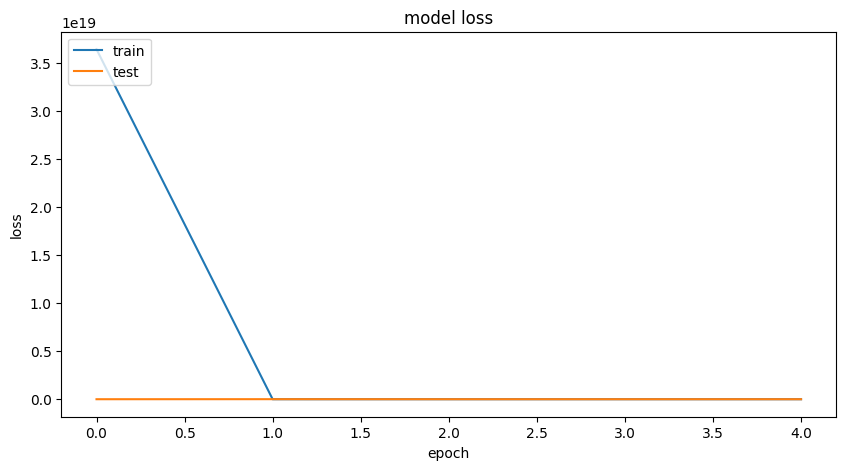

The loss for final model is  1.0883671045303345


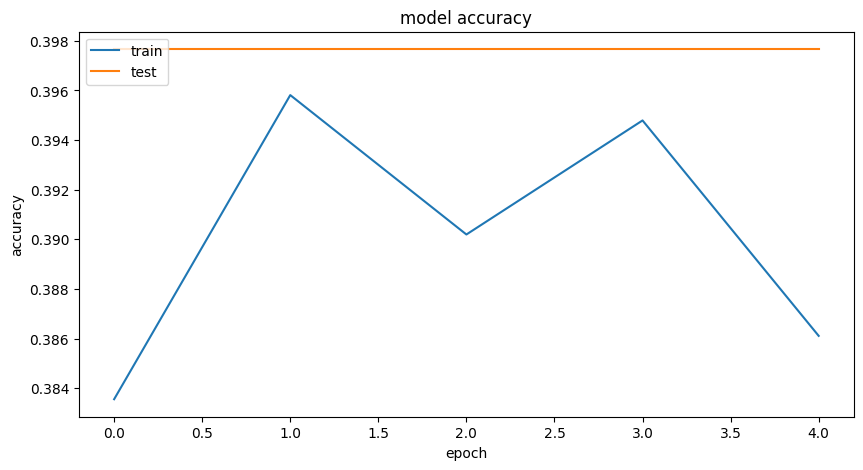

The accuracy for final model is  0.3976608216762543


In [79]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [80]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [81]:
best_model = load_model('densenet/densenet_stage3_fc-0.398.hdf5')

In [82]:
y_pred = best_model.predict(x_test)

171/171 [==============================] - 1492s 9s/step


In [83]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is nan
Average Recall is 0.3333333333333333
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_26600/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


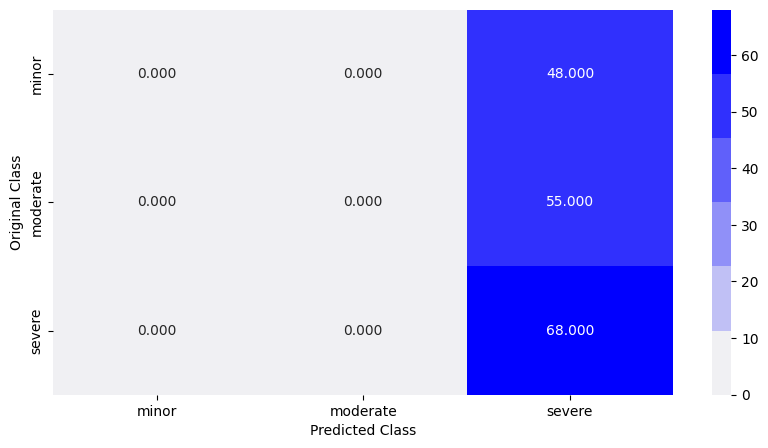

-------------------------------------------------- Precision Matrix --------------------------------------------------


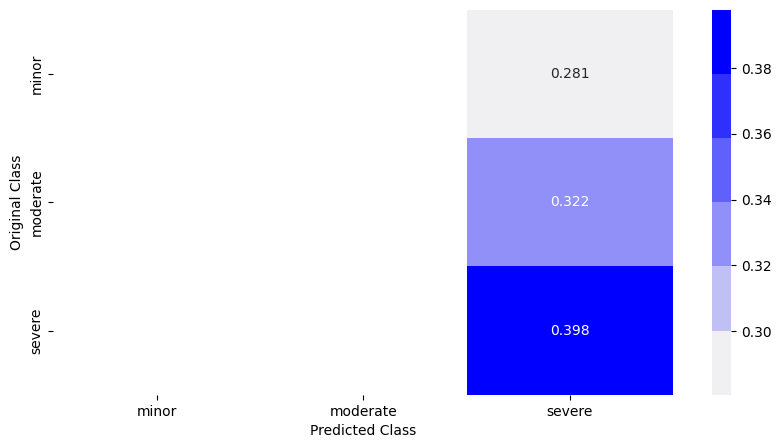

-------------------------------------------------- Recall Matrix --------------------------------------------------


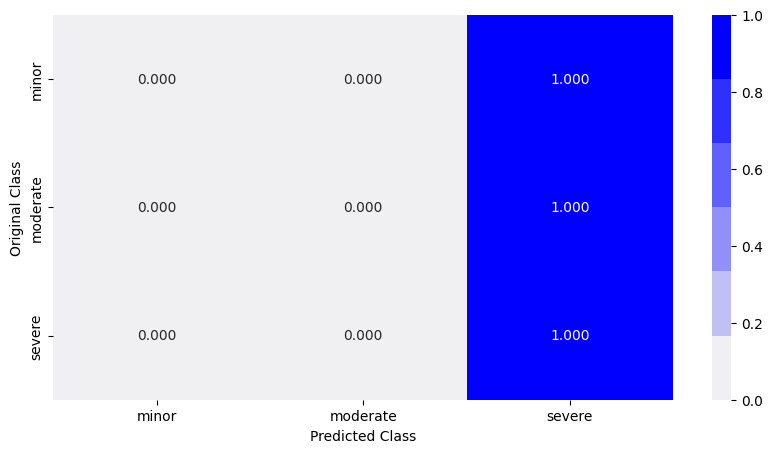

In [84]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [85]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage3 FC'], 'Accuracy': ['0.573'], 'Precision': ['0.578'], 'Recall': ['0.569']})], ignore_index=True)


### CNN (Training All layers only)

In [86]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    densenet = applications.DenseNet201(include_top=False,weights = 'imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(densenet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [87]:
model = create_model(1,'sigmoid')

In [88]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [89]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [90]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [91]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [92]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [93]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.


In [94]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=5,callbacks=[checkpoint])

Epoch 1/5
460/460 [==============================] - ETA: 0s - loss: 24.6513 - accuracy: 0.5007 
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to densenet/densenet_stage1_all-0.562.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


460/460 [==============================] - 19670s 39s/step - loss: 24.6513 - accuracy: 0.5007 - val_loss: 0.6868 - val_accuracy: 0.5625
Epoch 2/5
460/460 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.5053
Epoch 2: val_accuracy did not improve from 0.56250
460/460 [==============================] - 1963s 4s/step - loss: 0.6944 - accuracy: 0.5053 - val_loss: 0.6916 - val_accuracy: 0.5280
Epoch 3/5
460/460 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4977
Epoch 3: val_accuracy did not improve from 0.56250
460/460 [==============================] - 1203s 3s/step - loss: 0.6941 - accuracy: 0.4977 - val_loss: 0.6943 - val_accuracy: 0.4741
Epoch 4/5
460/460 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.4944
Epoch 4: val_accuracy did not improve from 0.56250
460/460 [==============================] - 763s 2s/step - loss: 0.6943 - accuracy: 0.4944 - val_loss: 0.6929 - val_accuracy: 0.5129
Epoch 5/5
460/460 [=========

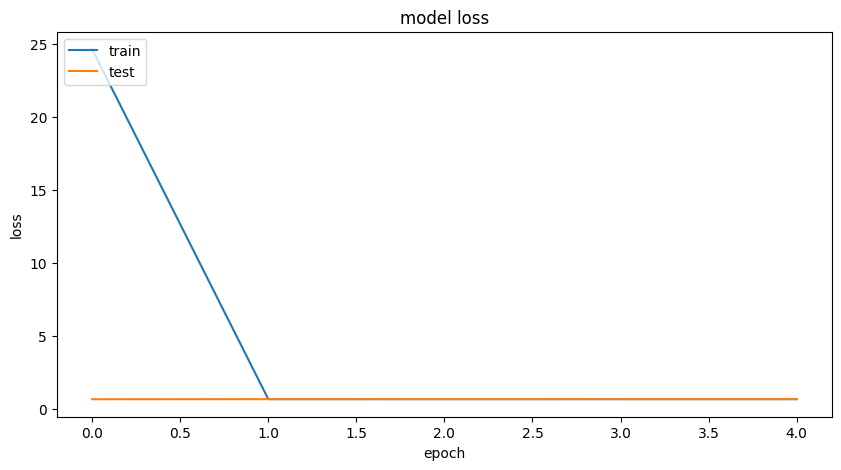

The loss for final model is  0.6867928504943848


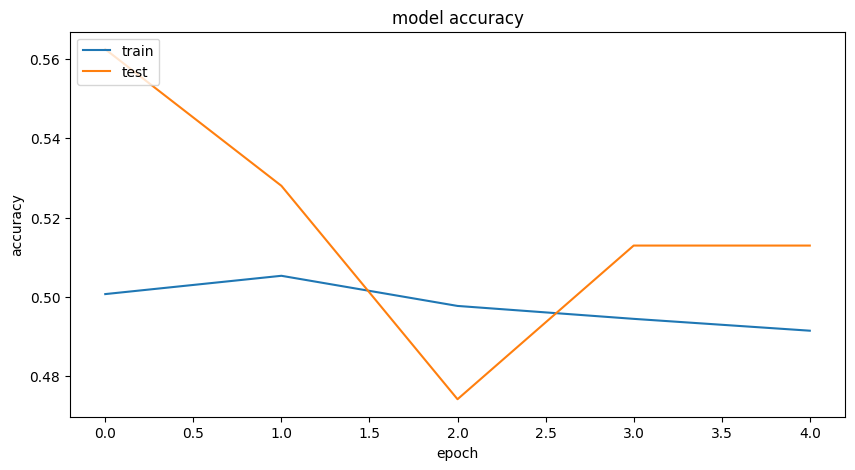

The accuracy for final model is  0.5625


In [95]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [96]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1633 images belonging to 2 classes.


In [97]:
best_model = load_model('densenet/densenet_stage1_all-0.560.hdf5')

In [98]:
y_pred = best_model.predict(x_test)

1633/1633 [==============================] - 164s 100ms/step


In [99]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.5202453987730061
Recall on test data for final baseline model 0.9976470588235294
-------------------------------------------------- Confusion matrix --------------------------------------------------


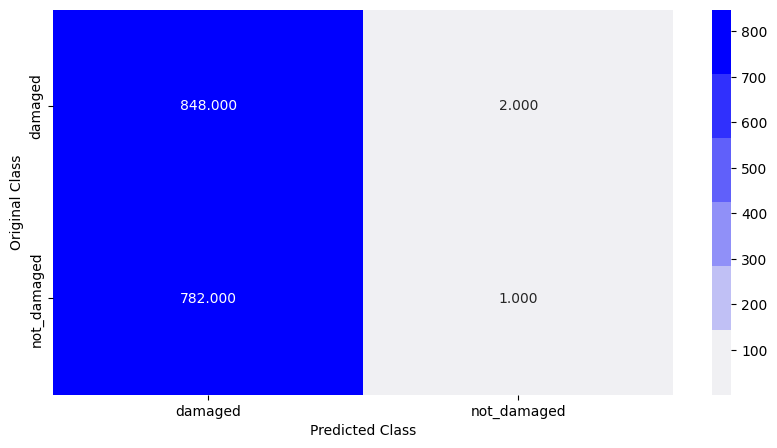

In [100]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [101]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage1 all'], 'Accuracy': ['0.959'], 'Precision': ['0.949'], 'Recall': ['0.970']})], ignore_index=True)


### Stage 2

In [102]:
model = create_model(3,'softmax')

In [103]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [104]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [105]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [106]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [107]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [108]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [109]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=5,callbacks=[checkpoint])

Epoch 1/5
247/246 [==============================] - ETA: -1s - loss: 59898.3633 - accuracy: 0.3659
Epoch 1: val_accuracy improved from -inf to 0.40782, saving model to densenet/densenet_stage2_all-0.408.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 504s 2s/step - loss: 59898.3633 - accuracy: 0.3659 - val_loss: 213591.5312 - val_accuracy: 0.4078
Epoch 2/5
247/246 [==============================] - ETA: -1s - loss: 1.3345 - accuracy: 0.3618
Epoch 2: val_accuracy did not improve from 0.40782
246/246 [==============================] - 469s 2s/step - loss: 1.3345 - accuracy: 0.3618 - val_loss: 3051.7019 - val_accuracy: 0.4078
Epoch 3/5
247/246 [==============================] - ETA: -1s - loss: 1.0941 - accuracy: 0.3753
Epoch 3: val_accuracy did not improve from 0.40782
246/246 [==============================] - 497s 2s/step - loss: 1.0941 - accuracy: 0.3753 - val_loss: 1.1013 - val_accuracy: 0.2737
Epoch 4/5
247/246 [==============================] - ETA: -1s - loss: 1.0945 - accuracy: 0.3712
Epoch 4: val_accuracy improved from 0.40782 to 0.41341, saving model to densenet/densenet_stage2_all-0.413.hdf5
246/246 [==============================] - 489s 2s/step - loss: 1.0945 - accuracy: 0.3712 

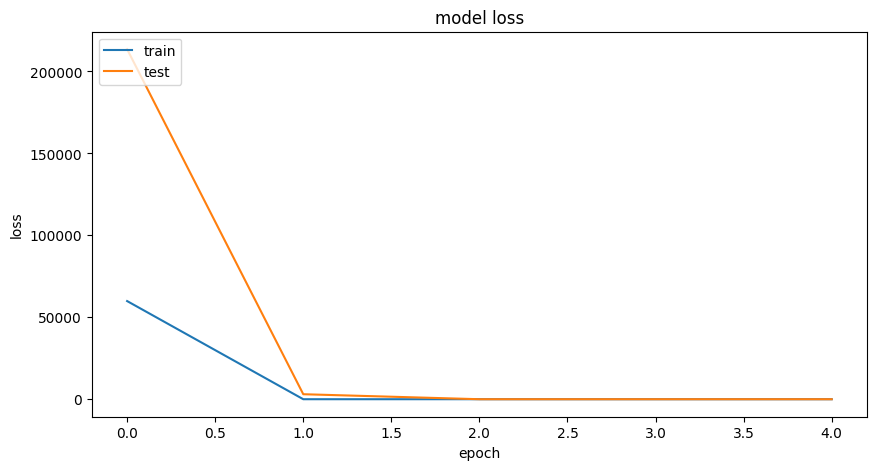

The loss for final model is  1.0885930061340332


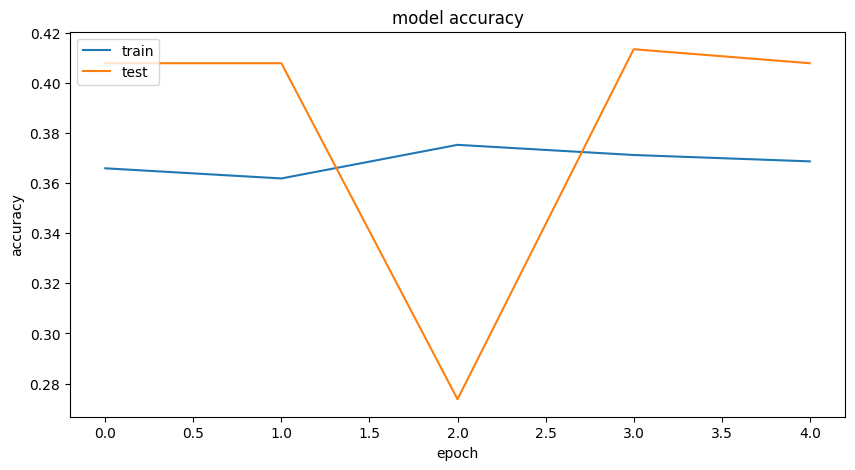

The accuracy for final model is  0.4134078323841095


In [110]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [111]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [112]:
best_model = load_model('densenet/densenet_stage2_all-0.402.hdf5')

In [113]:
y_pred = best_model.predict(x_test)

179/179 [==============================] - 18s 92ms/step


In [114]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is nan
Average Recall is 0.3287671232876712
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_26600/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


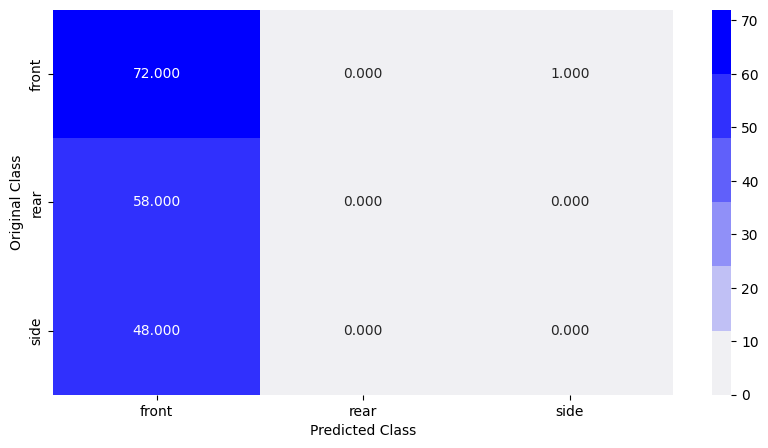

-------------------------------------------------- Precision Matrix --------------------------------------------------


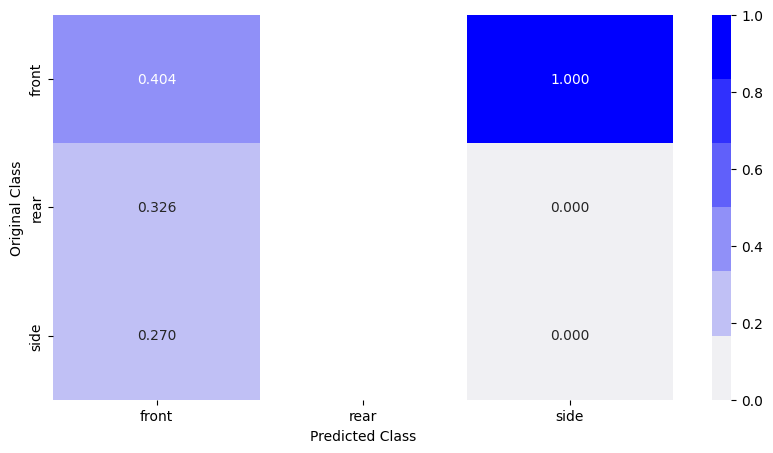

-------------------------------------------------- Recall Matrix --------------------------------------------------


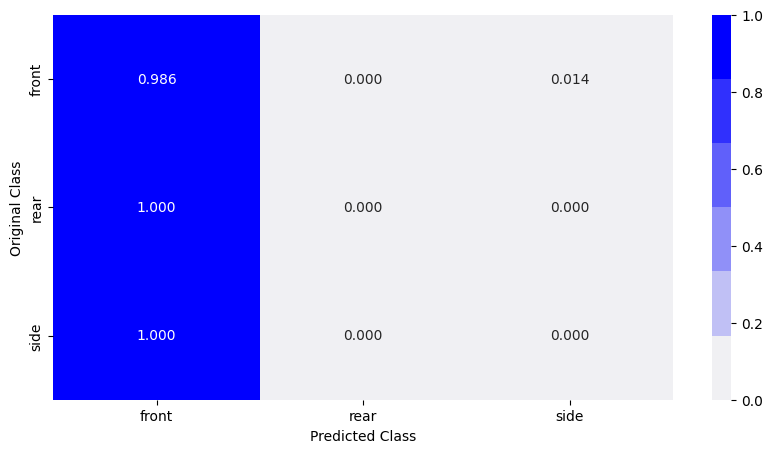

In [115]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [116]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage2 all'], 'Accuracy': ['0.804'], 'Precision': ['0.807'], 'Recall': ['0.789']})], ignore_index=True)


### Stage 3

In [117]:
model = create_model(3,'softmax')

In [118]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [119]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']      

In [120]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [121]:
#Model saving based on validation accuracy score
filepath="densenet/densenet_stage3_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [122]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [123]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [124]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

245/244 [==============================] - ETA: 0s - loss: 271.2775 - accuracy: 0.3744
Epoch 1: val_accuracy improved from -inf to 0.36257, saving model to densenet/densenet_stage3_all-0.363.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


244/244 [==============================] - 370s 1s/step - loss: 271.2775 - accuracy: 0.3744 - val_loss: 88188720.0000 - val_accuracy: 0.3626


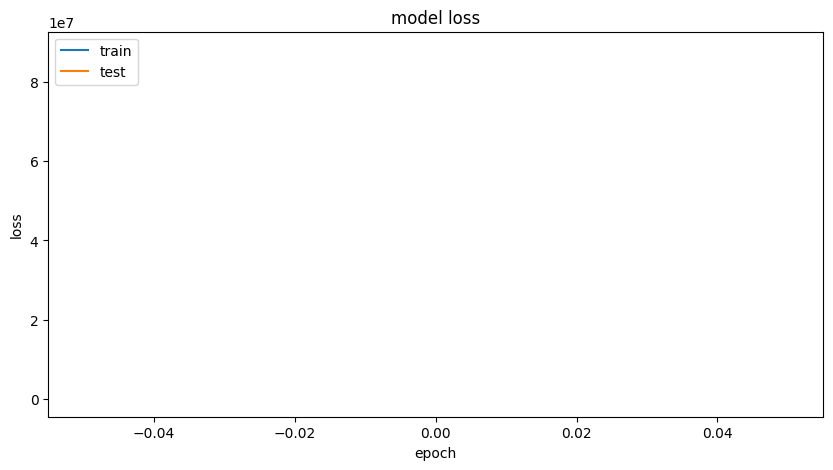

The loss for final model is  88188720.0


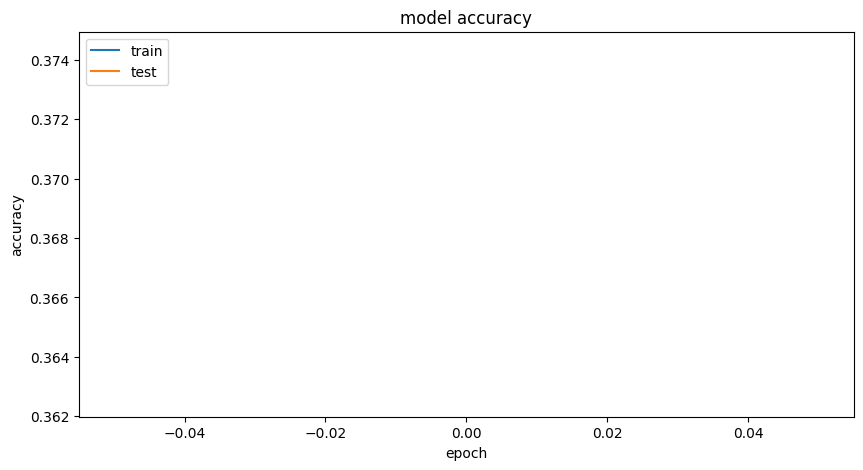

The accuracy for final model is  0.3625730872154236


In [125]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [126]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [128]:
best_model = load_model('densenet/densenet_stage3_all-0.363.hdf5')

In [129]:
y_pred = best_model.predict(x_test)

171/171 [==============================] - 19s 97ms/step


In [130]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is nan
Average Recall is 0.3537433155080214
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_26600/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


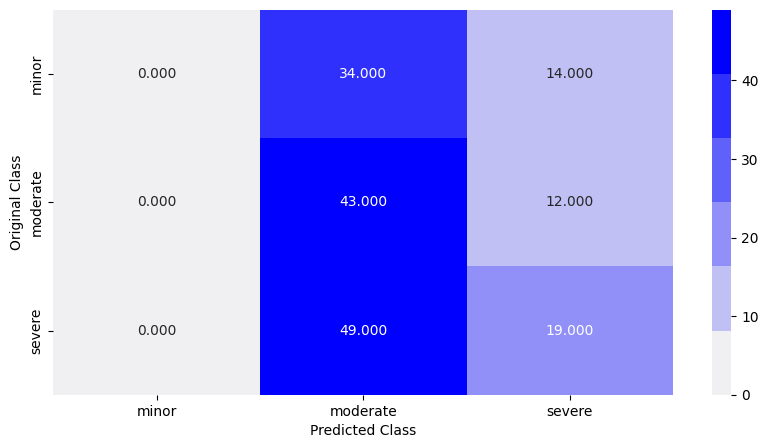

-------------------------------------------------- Precision Matrix --------------------------------------------------


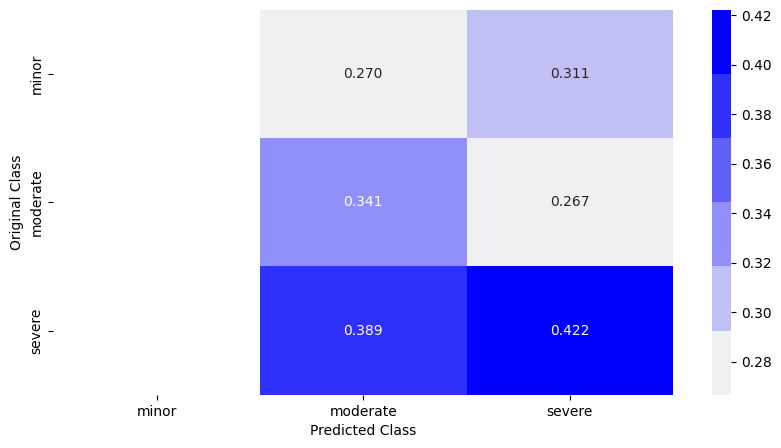

-------------------------------------------------- Recall Matrix --------------------------------------------------


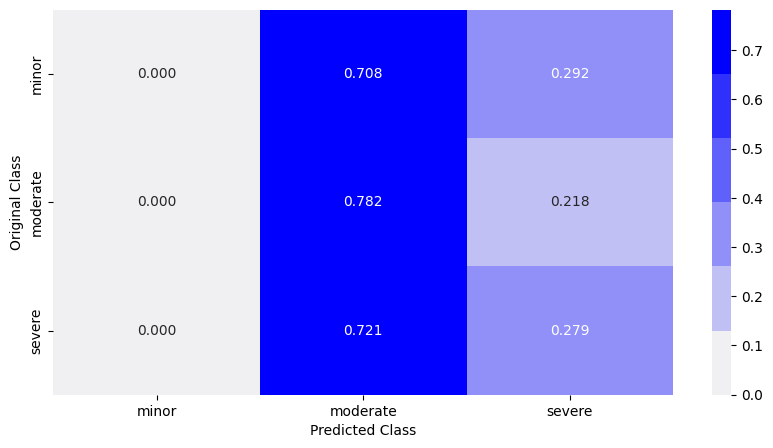

In [131]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [132]:
densenet_scores = pd.concat([densenet_scores, pd.DataFrame({'Model': ['Densenet_stage3 all'], 'Accuracy': ['0.696'], 'Precision': ['0.692'], 'Recall': ['0.685']})], ignore_index=True)

In [133]:
densenet_scores.to_csv('densenet_scores.csv',index=False)